[0.003337824774623213, 0.9632732732449317, 0.9445430816429295, 0.005224665422629738, 0.008558370112268775]
[4.929826211262461, 19.300336571922198, 0.23388943571590207, 0.48135741799921056, 0.5392656781344832]


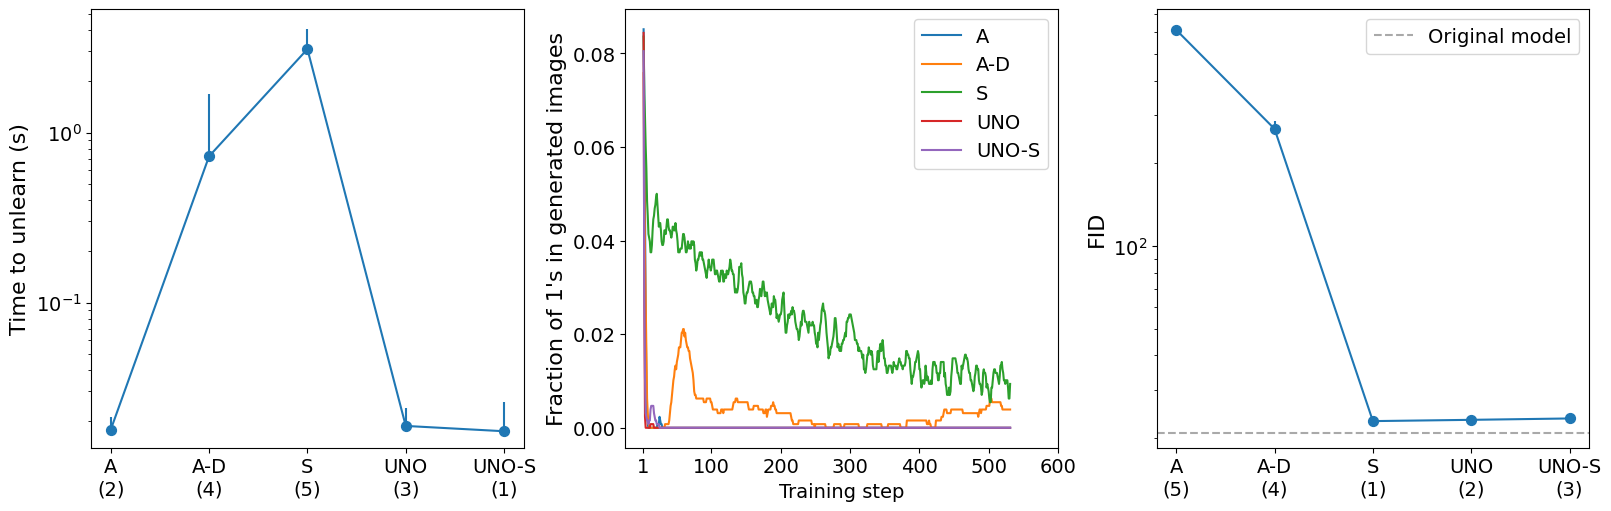

In [1]:
import os, sys, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../../modules'))
sys.path.append(os.path.abspath('../../modules/mnist'))
import vae_train as vt
import vae_ortho as vo
import vae_surgery as vs
import vae_os as vos
import vae_ascent as va
import vae_ad as vad
import classifier as cl
import batch as bt
import utility as ut
import vae_viz as viz
import datapipe


device = ut.get_device()
root = '../../data/MNIST/MNIST-Experiments'
mnist_folder = '../../data/MNIST'

algorithms = {"folders": [], "labels": [], }

algorithms["folders"].append(f"{root}/vae-a")
algorithms["labels"].append("A")

algorithms["folders"].append(f"{root}/vae-ad")
algorithms["labels"].append("A-D")

# algorithms["folders"].append(f"{root}/vae-hat")
# algorithms["labels"].append(r"$\hat{.}$")

algorithms["folders"].append(f"{root}/vae-s")
algorithms["labels"].append("S")

# algorithms["folders"].append(f"{root}/vae-shat")
# algorithms["labels"].append(r"$\hat{S}$")

algorithms["folders"].append(f"{root}/vae-o")
algorithms["labels"].append(r"UNO")

# algorithms["folders"].append(f"{root}/vae-ohat")
# algorithms["labels"].append(r"$\hat{O}$")

algorithms["folders"].append(f"{root}/vae-os")
algorithms["labels"].append(r"UNO-S")

# algorithms["folders"].append(f"{root}/vae-ohatshat")
# algorithms["labels"].append(r"$\hat{O}\hat{S}$")

bc = bt.BatchCompare(algorithms["folders"], algorithms["labels"])
# bc.plot("8 Fraction", "3 Fraction")
bc.plot2(logs=[1, True], rank=True)
plt.savefig("../../plots/mnist.pdf")#, bbox_inches="tight")

/Users/pman0581/miniconda3/envs/metal/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


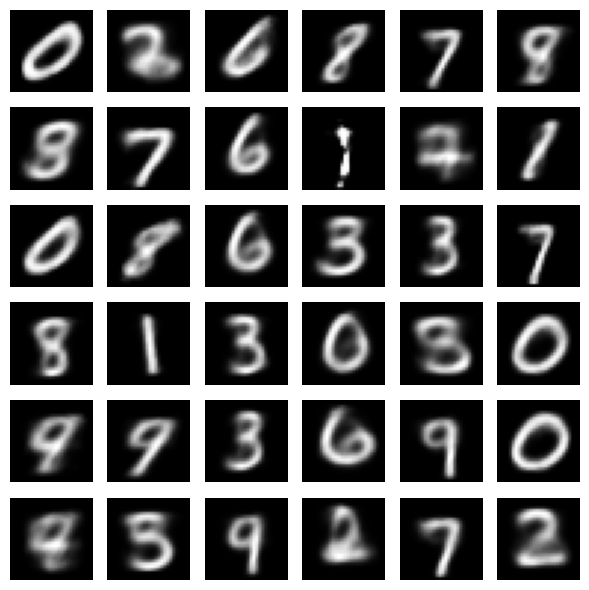

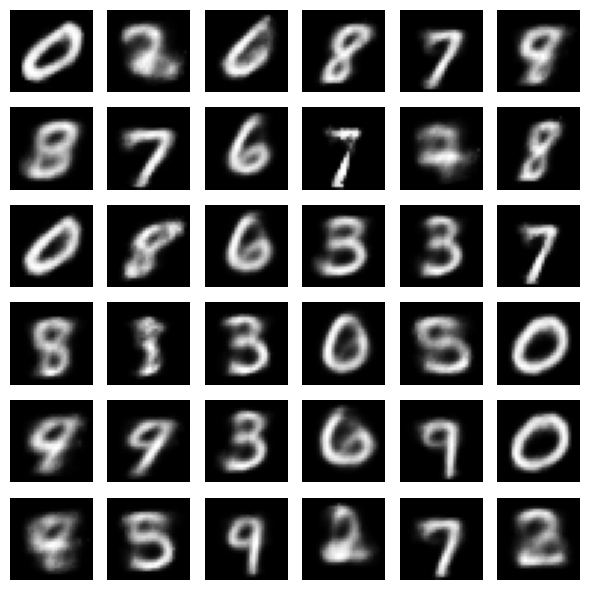

In [2]:
path_a = f'{mnist_folder}/vae/vae_200.pth'
path_b = f'{root}/vae-o/expr-0/checkpoints/vae_epoch_10.pth'
model_a = vt.init_model(path_a, 2, 'mps')
model_b = vt.init_model(path_b, 2, 'mps')
model_a.to('mps')
fig_a, fig_b = viz.compare_generated_samples(model_a, model_b, num_samples=36, bm=0, seed=81);
# fig.savefig('../../plots/mnist_transformation.pdf', bbox_inches="tight")

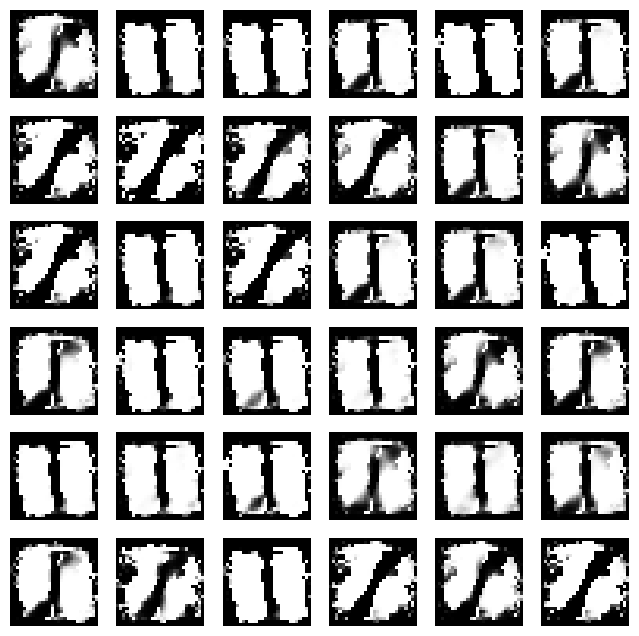

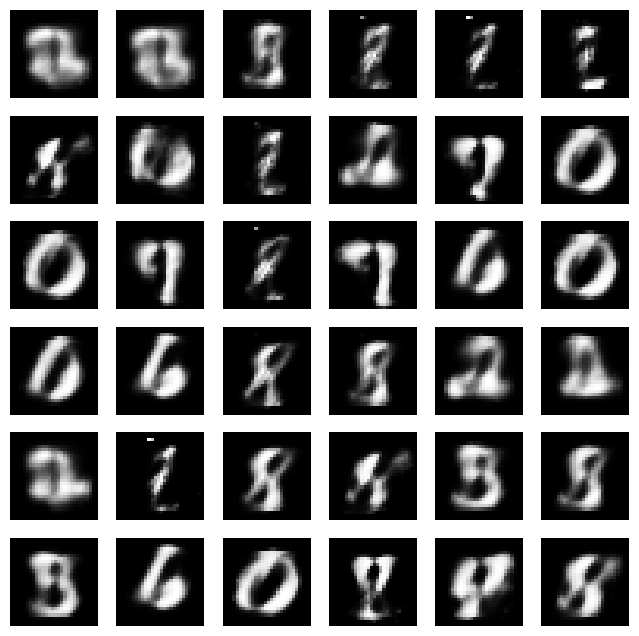

In [6]:
model_s_b = vt.init_model(f'{root}/vae-sa/expr-0/checkpoints/vae_epoch_1.pth', 2, 'mps')
model_s_s = vt.init_model(f'{root}/vae-sa-lr-0_00001/expr-0/checkpoints/vae_epoch_10.pth', 2, 'mps')

fig1, axes1 = viz.generate_random_samples(model_s_b, 36)
fig2, axes2 = viz.generate_random_samples(model_s_s, 36);

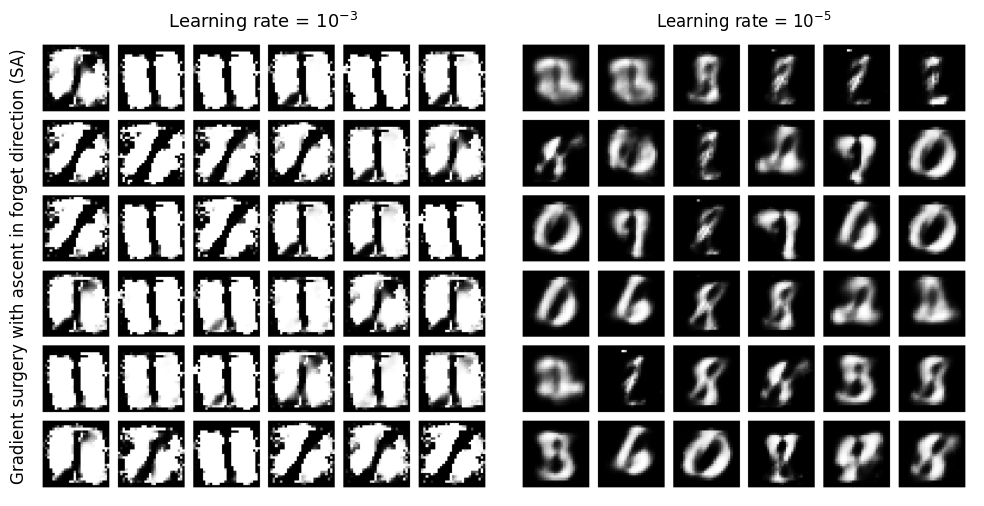

In [7]:
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image

def combine_grayscale_figures(fig1, fig2, titles=("Left", "Right"), ylabel=None):
    # Render fig1 to grayscale image
    buf1 = io.BytesIO()
    FigureCanvas(fig1).print_png(buf1)
    img1 = Image.open(buf1).convert("L")  # Grayscale
    img1_np = np.array(img1)

    # Render fig2 to grayscale image
    buf2 = io.BytesIO()
    FigureCanvas(fig2).print_png(buf2)
    img2 = Image.open(buf2).convert("L")
    img2_np = np.array(img2)

    # Resize to same height if needed
    if img1_np.shape[0] != img2_np.shape[0]:
        new_height = min(img1_np.shape[0], img2_np.shape[0])
        img1_np = np.array(Image.fromarray(img1_np).resize((int(img1_np.shape[1] * new_height / img1_np.shape[0]), new_height)))
        img2_np = np.array(Image.fromarray(img2_np).resize((int(img2_np.shape[1] * new_height / img2_np.shape[0]), new_height)))

    # Create new side-by-side figure with titles
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img1_np, cmap="gray")
    axes[0].set_title(titles[0], fontsize=13)
    axes[0].set_ylabel(ylabel, fontsize=12)
    # Hide ticks and spines, but NOT the whole axis
    axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in axes[0].spines.values():
        spine.set_visible(False)

    axes[1].imshow(img2_np, cmap="gray")
    axes[1].set_title(titles[1])
    axes[1].axis("off")

    # fig.subplots_adjust(wspace=0.0)
    plt.tight_layout()
    plt.show()

    return fig

fig1.tight_layout()
fig2.tight_layout()
fig = combine_grayscale_figures(fig1, fig2,\
                                            titles=[r"Learning rate = $10^{-3}$", r"Learning rate = $10^{-5}$"],\
                                            ylabel="Gradient surgery with ascent in forget direction (SA)")
fig.savefig('../../plots/sa_lr.pdf', bbox_inches="tight")

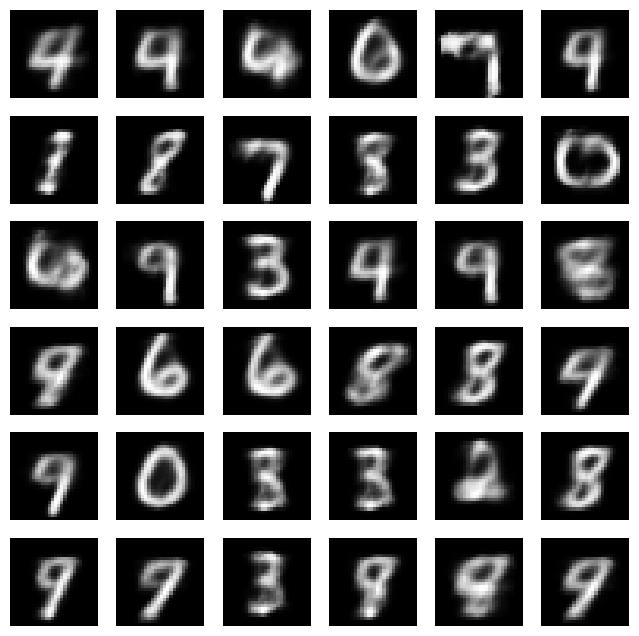

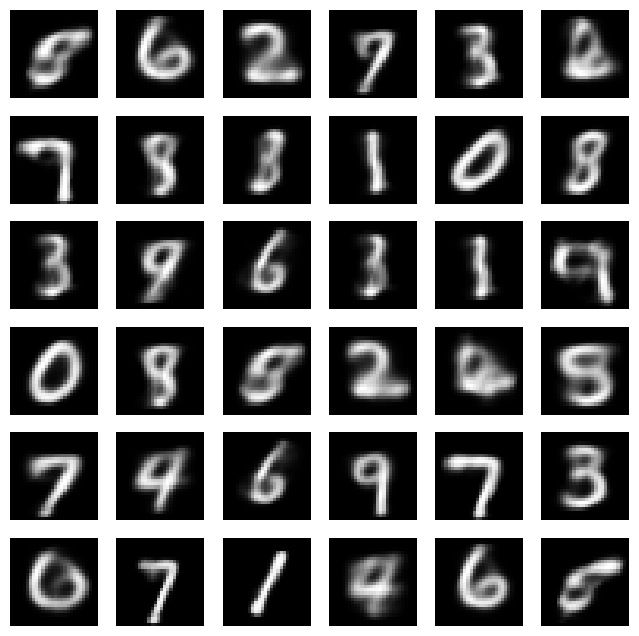

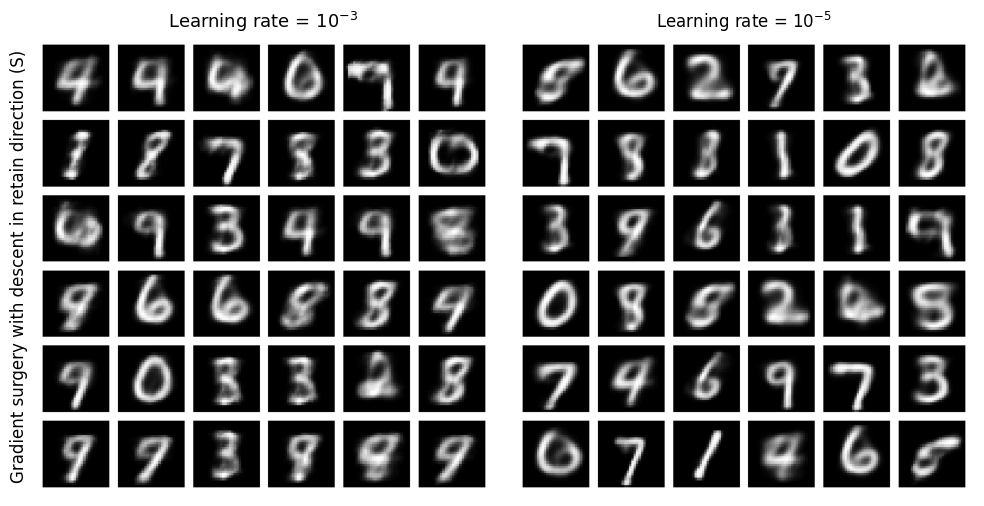

In [8]:
model_s_b = vt.init_model(f'{root}/vae-s/expr-0/checkpoints/vae_epoch_10.pth', 2, 'mps')
model_s_s = vt.init_model(f'{root}/vae-s-lr-0_00001/expr-0/checkpoints/vae_epoch_10.pth', 2, 'mps')

fig1, axes1 = viz.generate_random_samples(model_s_b, 36)
fig2, axes2 = viz.generate_random_samples(model_s_s, 36);
fig1.tight_layout()
fig2.tight_layout()
fig = combine_grayscale_figures(fig1, fig2,\
                                            titles=[r"Learning rate = $10^{-3}$", r"Learning rate = $10^{-5}$"],\
                                            ylabel="Gradient surgery with descent in retain direction (S)")
fig.savefig('../../plots/s_lr.pdf', bbox_inches="tight")

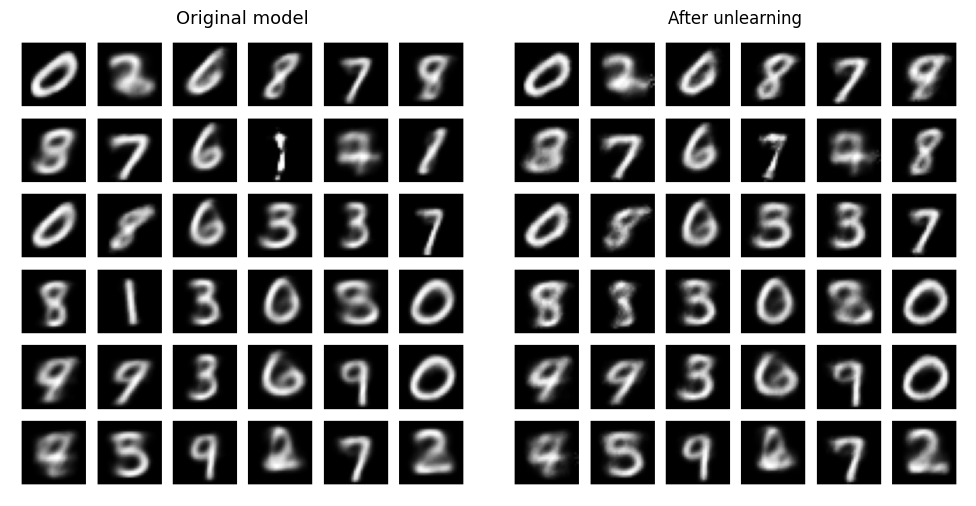

In [5]:
fig_a.tight_layout()
fig_b.tight_layout()
fig = combine_grayscale_figures(fig_a, fig_b,\
                                            titles=[r"Original model", "After unlearning"],\
                                            ylabel="")
fig.savefig('../../plots/mnist_transformation.pdf', bbox_inches="tight")

In [9]:
ut.count_params(model_a)

(632788, 632788)

In [8]:
n, device = 500, 'mps'
cls = cl.get_classifier('../../data/MNIST/classifiers/MNISTClassifier.pth', 'mps')
z_random = torch.randn(n, 2).to(device)
gen = model_a.decoder(z_random)
logits = cls(gen)
c0 = cl.count_from_logits(logits)
gen = model_b.decoder(z_random)
logits = cls(gen)
c1 = cl.count_from_logits(logits)

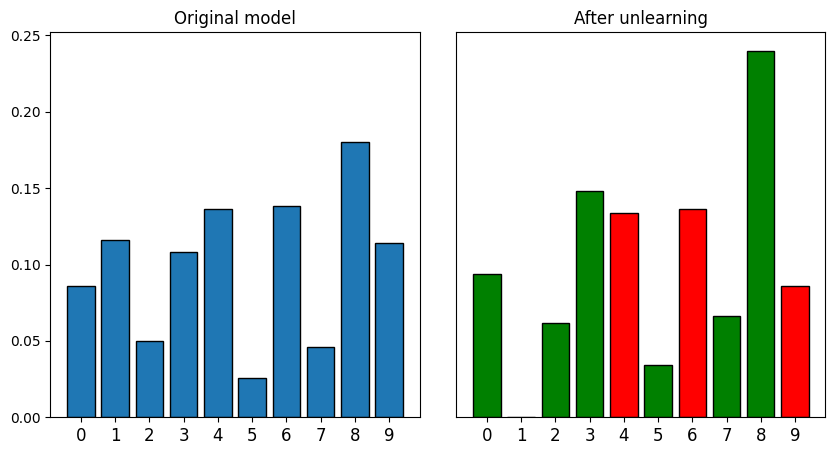

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming c0, c1 are tensors and n is a scalar
vals0 = (c0.cpu().numpy() / n)
vals1 = (c1.cpu().numpy() / n)

# Define colors based on comparison
colors = []
for v0, v1 in zip(vals0, vals1):
    if v1 > v0:
        colors.append('green')  # Increased in c1
    elif v1 < v0:
        colors.append('red')    # Decreased in c1
    else:
        colors.append('blue')   # Same

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Left panel (original model)
ax[0].bar(range(10), vals0, edgecolor='black')
# ax[0].set_ylabel("Fraction in generated images", fontsize=12)
ax[0].set_title("Original model", fontsize=12)
ax[0].set_xticks(range(10))
ax[0].tick_params(axis='x', labelsize=12)

# Right panel (after unlearning) with conditional colors
ax[1].bar(range(10), vals1, color=colors, edgecolor='black')
ax[1].set_title("After unlearning", fontsize=12)
ax[1].set_xticks(range(10))
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(left=False, labelleft=False)

fig.subplots_adjust(wspace=0.1)
fig.savefig(f'../../plots/mnist_dist.pdf', bbox_inches='tight')


In [14]:
c0

tensor([43, 58, 25, 54, 68, 13, 69, 23, 90, 57], device='mps:0')